# Client Embeddings Using Neural Networks (Auto Encoders)

Currently CD manually groups clients using:

- Zones
- Score tiers
- Council bands
- Contactability , etc


But thats fixed. We let AI auto group the clients based on hidden patterns?

These embeddings allow us to:

- Visually group clients into clusters using 2D plots
-  Detect new segments (e.g., clients who always repay fast, even if their scores are weird)
- Use embeddings as inputs to better models (e.g, for predicting payment behavior)

## Training Inputs

- Arrears
- dp1 Score
- dp3 Score
- Residency Zone (encoded)
- Occupancy Style (encoded)
- Mobile Flag (Y/N → 1/0)
- Email Flag (Y/N → 1/0)


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
# data
df = pd.read_csv("/Users/rg/ACADEMICS/Interview/Connected Data Comapany/MAY/Dataset/Unique_Scores_for_Client/clients_sorted_by_risk.csv")

# input features
features = ['Arrears Balance', 'dp1 Score', 'dp3 Score', 'Residency Zone', 
            'dp2 Occupancy Style', 'Mobile Flag', 'Email Flag']
X = df[features].copy()

#  encode categorical variables
X['Residency Zone'] = X['Residency Zone'].astype(str)
X['dp2 Occupancy Style'] = X['dp2 Occupancy Style'].astype(str)
X['Mobile Flag'] = X['Mobile Flag'].str.strip().str.upper().fillna("N")
X['Email Flag'] = X['Email Flag'].str.strip().str.upper().fillna("N")

# preprocessing
numeric_features = ['Arrears Balance', 'dp1 Score', 'dp3 Score']
categorical_features = ['Residency Zone', 'dp2 Occupancy Style', 'Mobile Flag', 'Email Flag']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_processed = preprocessor.fit_transform(X)

# Autoencoder
input_dim = X_processed.shape[1]
encoding_dim = 2  # Compressinf into 2 dimensions

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='linear', name="embedding")(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Training
autoencoder.fit(X_processed, X_processed, epochs=50, batch_size=32, verbose=1)

# Extracting the embeddings from the encoder part
encoder = Model(inputs=input_layer, outputs=autoencoder.get_layer("embedding").output)
embeddings = encoder.predict(X_processed)

# Adding embeddings to DataFrame
df['Embed_X'] = embeddings[:, 0]
df['Embed_Y'] = embeddings[:, 1]

#  output
df[['UID', 'Embed_X', 'Embed_Y']].to_csv(
    "/Users/rg/ACADEMICS/Interview/Connected Data Comapany/MAY/Dataset/Client_Embeddings_NN/clients_with_embeddings.csv", index=False)

print(" Client embeddings generated and saved.")


2025-05-01 13:52:51.963467: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-01 13:52:52.040888: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
18/18 [==============================] - 0s 467us/step - loss: 0.4883
Epoch 2/50
18/18 [==============================] - 0s 378us/step - loss: 0.4313
Epoch 3/50
18/18 [==============================] - 0s 355us/step - loss: 0.3981
Epoch 4/50
18/18 [==============================] - 0s 393us/step - loss: 0.3421
Epoch 5/50
18/18 [==============================] - 0s 399us/step - loss: 0.2891
Epoch 6/50
18/18 [==============================] - 0s 382us/step - loss: 0.2290
Epoch 7/50
18/18 [==============================] - 0s 350us/step - loss: 0.1970
Epoch 8/50
18/18 [==============================] - 0s 367us/step - loss: 0.1730
Epoch 9/50
18/18 [==============================] - 0s 339us/step - loss: 0.1597
Epoch 10/50
18/18 [==============================] - 0s 350us/step - loss: 0.1416
Epoch 11/50
18/18 [==============================] - 0s 331us/step - loss: 0.1359
Epoch 12/50
18/18 [==============================] - 0s 358us/step - loss: 0.1255
Epoch 13/50
18/18 [======

## visualisation

In [4]:
import pandas as pd

# data merging
embeddings_df = pd.read_csv("/Users/rg/ACADEMICS/Interview/Connected Data Comapany/MAY/Dataset/Client_Embeddings_NN/clients_with_embeddings.csv")
client_data_df = pd.read_csv("/Users/rg/ACADEMICS/Interview/Connected Data Comapany/MAY/Dataset/Anomaly_Detection/clients_sorted_by_anomalies.csv")  

# Merging based on UID
merged_df = pd.merge(embeddings_df, client_data_df, on="UID", how="left")

# merged dataset
merged_df.to_csv("/Users/rg/ACADEMICS/Interview/Connected Data Comapany/MAY/Dataset/Client_Embeddings_NN/clients_embeddings_with_risk_tier.csv", index=False)
print(" Merged dataset saved as 'clients_embeddings_with_risk_tier.csv'")


 Merged dataset saved as 'clients_embeddings_with_risk_tier.csv'


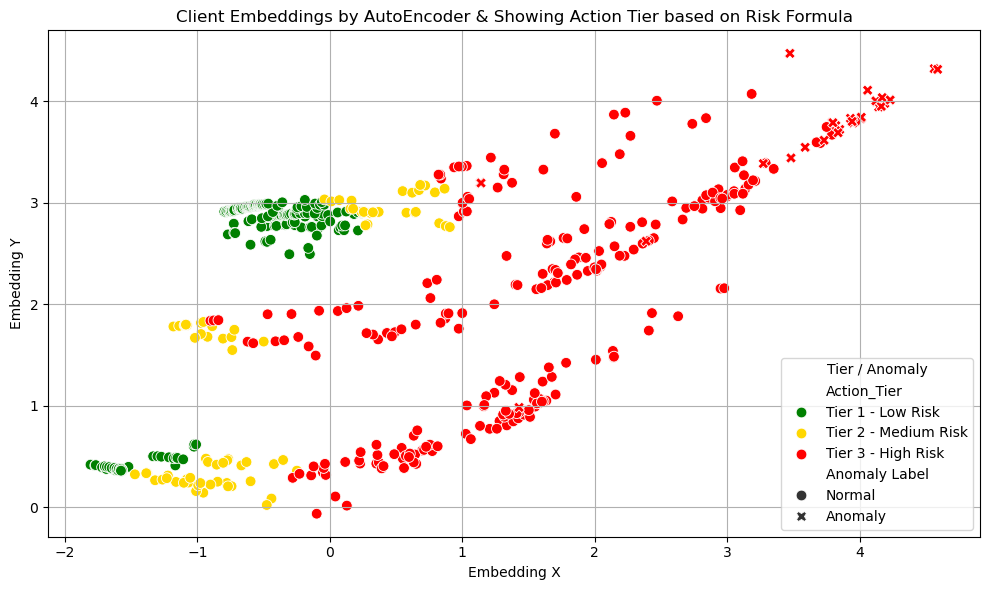

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# dataset
df = pd.read_csv("/Users/rg/ACADEMICS/Interview/Connected Data Comapany/MAY/Dataset/Client_Embeddings_NN/clients_embeddings_with_risk_tier.csv")

#  custom 
custom_paletteting = {
    'Tier 1 - Low Risk': 'green',
    'Tier 2 - Medium Risk': 'gold',
    'Tier 3 - High Risk': 'red'
}

# plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Embed_X',
    y='Embed_Y',
    hue='Action_Tier',
    style='Anomaly Label',
    s=60,
    palette=custom_palette
)


plt.title('Client Embeddings by AutoEncoder & Showing Action Tier based on Risk Formula')
plt.xlabel('Embedding X')
plt.ylabel('Embedding Y')
plt.legend(title='Tier / Anomaly')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# embeddings data
df = pd.read_csv("/Users/rg/ACADEMICS/Interview/Connected Data Comapany/MAY/Dataset/Client_Embeddings_NN/clients_embeddings_with_risk_tier.csv")

# Filter cluster 1 (Top left group) - 
cluster1 = df[
    (df['Embed_X'] >= -1.2) & (df['Embed_X'] <= 0.2) &
    (df['Embed_Y'] >= 2.5) & (df['Embed_Y'] <= 3.5)
]

# Filter cluster 2 (Bottom left group)
cluster2 = df[
    (df['Embed_X'] >= -1.8) & (df['Embed_X'] <= -0.5) &
    (df['Embed_Y'] >= 0.1) & (df['Embed_Y'] <= 0.8)
]

# Combine both
combined_clusters = pd.concat([cluster1, cluster2])

# CSV
combined_clusters.to_csv("/Users/rg/ACADEMICS/Interview/Connected Data Comapany/MAY/Dataset/Client_Embeddings_NN/clients_from_selected_clusters.csv", index=False)

print("Extracted clients from visual clusters and saved to file.")


Extracted clients from visual clusters and saved to file.
